In [3]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
folder_path = "/kaggle/input/utkface-new/UTKFace"

In [5]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  if not file.endswith(".jpg"):
    continue

  try:
    age.append(file.split("_")[0])
    gender.append(file.split("_")[1])
    img_path.append(file)
  
  except (ValueError, IndexError):
    continue


In [6]:
len(age),len(gender),len(img_path)

(23708, 23708, 23708)

In [7]:
df = pd.DataFrame({"age":age,"gender":gender,"img":img_path})
df['age'] = df['age'].astype('int32')
df['gender'] = df['gender'].astype('int32')

In [8]:
df.head()

,age,gender,img
0,26,0,26_0_2_20170104023102422.jpg.chip.jpg
1,22,1,22_1_1_20170112233644761.jpg.chip.jpg
2,21,1,21_1_3_20170105003215901.jpg.chip.jpg
3,28,0,28_0_0_20170117180555824.jpg.chip.jpg
4,17,1,17_1_4_20170103222931966.jpg.chip.jpg


In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['gender'])

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(224,224),
                                                    class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(224,224),
                                                    class_mode='raw')

Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [12]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [13]:
resnet = ResNet50(include_top=False, input_shape=(224,224,3))

resnet.trainable=True

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

I0000 00:00:1753552398.527399      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753552398.528157      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
import keras
output = keras.layers.Concatenate()([output1, output2])

In [15]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

In [16]:
model.compile(optimizer='adam',  loss={'age': 'mae', 'gender': 'binary_crossentropy'},
    metrics={'age': 'mae', 'gender': 'accuracy'},
    loss_weights={'age': 1, 'gender': 99})

In [17]:
import tensorflow as tf

def split_labels_generator(generator):
    for imgs, labels in generator:
        # Reshape labels to (batch_size, 1)
        age = labels[:, 0].reshape(-1, 1)
        gender = labels[:, 1].reshape(-1, 1)
        yield imgs, (age, gender)

output_signature = (
    tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),   # images
    (
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32),         # age
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32),         # gender
    )
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: split_labels_generator(train_generator),
    output_signature=output_signature
)
val_dataset = tf.data.Dataset.from_generator(
    lambda: split_labels_generator(test_generator),
    output_signature=output_signature
)


In [18]:
for x, y in train_dataset.take(1):
    print(x.shape, type(y))


(32, 224, 224, 3) <class 'tuple'>


In [19]:
train_gen = split_labels_generator(train_generator)
val_gen = split_labels_generator(test_generator)

In [20]:
model.fit(train_dataset, steps_per_epoch=len(train_generator),
          validation_data=val_dataset, validation_steps=len(test_generator), epochs=10)

Epoch 1/10


I0000 00:00:1753552457.304544     102 service.cc:148] XLA service 0x79befc005c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753552457.306137     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753552457.306164     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753552462.561093     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753552487.321725     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 483s 674ms/step - age_loss: 20.6774 - age_mae: 20.6774 - gender_accuracy: 0.6258 - gender_loss: 1.7553 - loss: 194.4558 - val_age_loss: 28.6822 - val_age_mae: 28.6021 - val_gender_accuracy: 0.4783 - val_gender_loss: 0.6988 - val_loss: 97.7641
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 286s 483ms/step - age_loss: 10.8406 - age_mae: 10.8406 - gender_accuracy: 0.8270 - gender_loss: 0.3770 - loss: 48.1626 - val_age_loss: 12.5856 - val_age_mae: 12.5794 - val_gender_accuracy: 0.8319 - val_gender_loss: 0.3500 - val_loss: 47.2630
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 281s 474ms/step - age_loss: 9.9742 - age_mae: 9.9742 - gender_accuracy: 0.8600 - gender_loss: 0.3163 - loss: 41.2856 - val_age_loss: 10.5295 - val_age_mae: 10.4491 - val_gender_accuracy: 0.8608 - val_gender_loss: 0.3077 - val_loss: 40.8851
Epoch 4/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 281s 473ms/step - age_loss: 9.5182 - age_mae: 9.5182 - gender_accuracy: 0.8606 - gender_loss: 0.3015 - loss: 39.3628 - val_age

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np

test_path = '/kaggle/input/test-img3/myPhoto.jpeg'  # Update with image location

# Load and preprocess the image
t_img = image.load_img(test_path, target_size=(224, 224))
t_img_array = image.img_to_array(t_img)
t_img_array = t_img_array / 255.0                   # Rescale to match training
t_img_array = np.expand_dims(t_img_array, axis=0)   # Add batch dimension


In [22]:

import requests
from PIL import Image
from io import BytesIO

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ8OIwrCS1fxmeT5vzZiCwFbsJCPsTYxbaM_g&s'  # Replace with your image URL
response = requests.get(url)
t_img = Image.open(BytesIO(response.content)).convert('RGB')
t_img = t_img.resize((224, 224))
import numpy as np
t_img_array = np.array(t_img) / 255.0
t_img_array = np.expand_dims(t_img_array, axis=0)


In [23]:
# Model returns [age_pred, gender_pred]
preds = model.predict(t_img_array)

if isinstance(preds, list) or isinstance(preds, tuple):
    predicted_age = preds[0][0][0]      # [batch, 1], so take first
    predicted_gender = preds[1][0][0]   # Typically sigmoid output
else:
    predicted_age = preds[0][0]
    predicted_gender = preds[0][1]

gender_label = 'Female' if predicted_gender > 0.5 else 'Male'
print(f'Predicted Age: {predicted_age:.1f}')
print(f'Predicted Gender: {gender_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Age: 21.6
Predicted Gender: Male


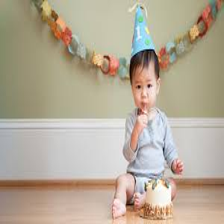

In [24]:
t_img

In [25]:
from tensorflow.keras.models import load_model
# If you have a model built & trained in notebook (model variable)
model.save('age_gender_model.h5')